<a href="https://colab.research.google.com/github/maame-dankwaa/Plant-Disease-Detection/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import os
from zipfile import ZipFile
import pickle
import json

In [ ]:
with ZipFile("/content/drive/My Drive/Afarinick Internship/archive.zip", 'r') as zip_ref:
    zip_ref.extractall()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Afarinick Internship/archive.zip'

In [ ]:
print(os.listdir('/content/'))
print()

['.config', 'drive', 'plantvillage', 'PlantVillage', 'sample_data']



In [ ]:
dataset_path = "/content/PlantVillage"
print(os.listdir(dataset_path))
print(len(os.listdir(dataset_path)))
classes = os.listdir(dataset_path)
print(f"Number of classes: {len(classes)}")
print("Classes:", classes[:10])

['Tomato_Early_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus', 'Tomato_Leaf_Mold', 'Tomato_Late_blight', 'Tomato_Septoria_leaf_spot', 'Pepper__bell___Bacterial_spot', 'Tomato_healthy', 'Potato___healthy', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Potato___Late_blight', 'Tomato__Target_Spot', 'Tomato_Bacterial_spot', 'Pepper__bell___healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite']
15
Number of classes: 15
Classes: ['Tomato_Early_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus', 'Tomato_Leaf_Mold', 'Tomato_Late_blight', 'Tomato_Septoria_leaf_spot', 'Pepper__bell___Bacterial_spot', 'Tomato_healthy', 'Potato___healthy', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


Data Exploration

In [ ]:
class_counts = {}
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))


(256, 256, 3)


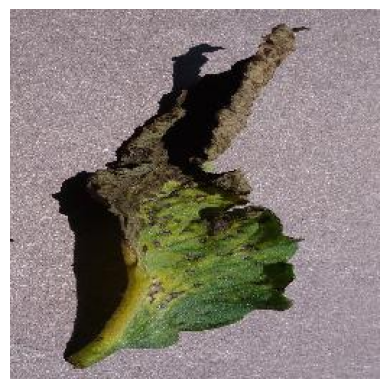

In [ ]:
image_path = "/content/PlantVillage/Tomato_Septoria_leaf_spot/0a5edec2-e297-4a25-86fc-78f03772c100___JR_Sept.L.S 8468.JPG"

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

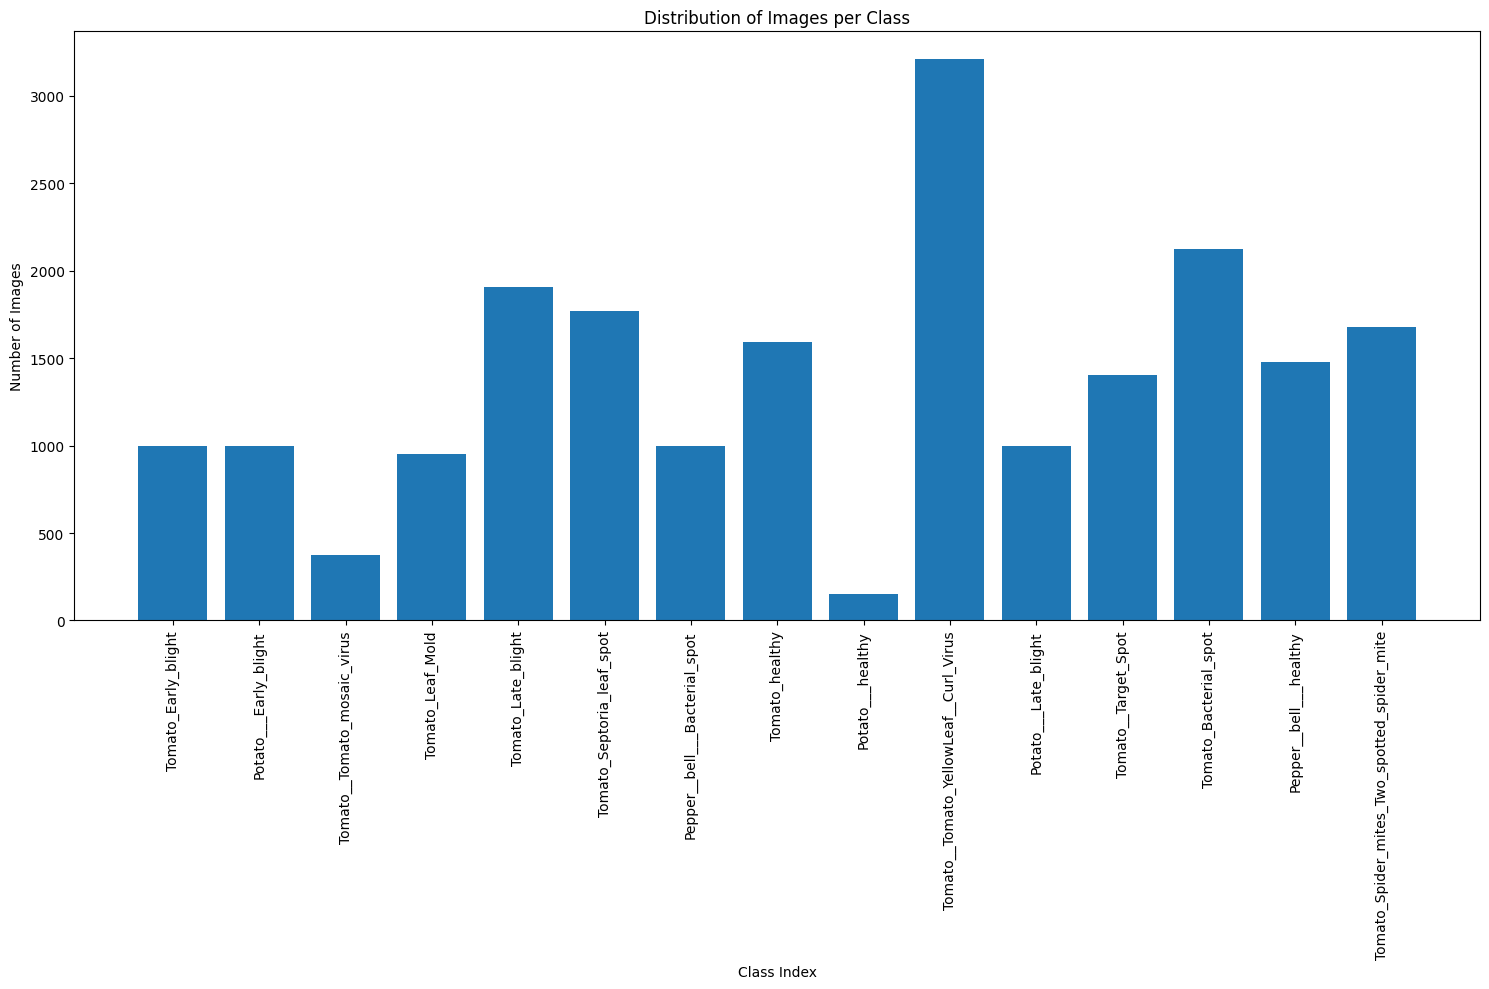

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(range(len(class_counts)), list(class_counts.values()))
plt.xlabel('Class Index')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(range(len(class_counts)), list(class_counts.keys()), rotation=90)
plt.tight_layout()
plt.show()

DATA PREPROCESSING

In [ ]:
#Parameters
img_size = (224, 224)
batchSize = 35
validationSplit = 0.2

In [ ]:
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validationSplit
)

In [ ]:
train_generator = train_datagenerator.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batchSize,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 16516 images belonging to 15 classes.


In [ ]:
validation_generator = train_datagenerator.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batchSize,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4122 images belonging to 15 classes.


In [ ]:
# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Number of classes: 15
Training samples: 16516
Validation samples: 4122


Building and Training the Model

In [ ]:
mobnet_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
resnet_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model = mobnet_model
base_model.trainable = False
model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001
    )
]

In [ ]:
#Training
history = model.fit(
    train_generator,
    epochs=90,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.3163 - loss: 2.2001
Epoch 1: val_accuracy improved from -inf to 0.71591, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 272s 551ms/step - accuracy: 0.3166 - loss: 2.1991 - val_accuracy: 0.7159 - val_loss: 0.9489 - learning_rate: 1.0000e-04
Epoch 2/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.6662 - loss: 1.0580
Epoch 2: val_accuracy improved from 0.71591 to 0.78069, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 308s 536ms/step - accuracy: 0.6663 - loss: 1.0578 - val_accuracy: 0.7807 - val_loss: 0.6809 - learning_rate: 1.0000e-04
Epoch 3/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7207 - loss: 0.8536
Epoch 3: val_accuracy improved from 0.78069 to 0.80859, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 277s 587ms/step - accuracy: 0.7207 - loss: 0.8536 - val_accuracy: 0.8086 - val_loss: 0.5767 - learning_rate: 1.0000e-04
Epoch 4/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7619 - loss: 0.7328
Epoch 4: val_accuracy improved from 0.80859 to 0.82921, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 244s 517ms/step - accuracy: 0.7619 - loss: 0.7327 - val_accuracy: 0.8292 - val_loss: 0.5201 - learning_rate: 1.0000e-04
Epoch 5/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7901 - loss: 0.6566
Epoch 5: val_accuracy improved from 0.82921 to 0.84837, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 260s 514ms/step - accuracy: 0.7901 - loss: 0.6566 - val_accuracy: 0.8484 - val_loss: 0.4834 - learning_rate: 1.0000e-04
Epoch 6/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8025 - loss: 0.6081
Epoch 6: val_accuracy did not improve from 0.84837
472/472 ━━━━━━━━━━━━━━━━━━━━ 242s 513ms/step - accuracy: 0.8025 - loss: 0.6081 - val_accuracy: 0.8474 - val_loss: 0.4585 - learning_rate: 1.0000e-04
Epoch 7/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8045 - loss: 0.5796
Epoch 7: val_accuracy improved from 0.84837 to 0.86342, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 244s 517ms/step - accuracy: 0.8045 - loss: 0.5796 - val_accuracy: 0.8634 - val_loss: 0.4186 - learning_rate: 1.0000e-04
Epoch 8/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8152 - loss: 0.5511
Epoch 8: val_accuracy improved from 0.86342 to 0.86633, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 276s 585ms/step - accuracy: 0.8152 - loss: 0.5511 - val_accuracy: 0.8663 - val_loss: 0.4053 - learning_rate: 1.0000e-04
Epoch 9/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8262 - loss: 0.5252
Epoch 9: val_accuracy improved from 0.86633 to 0.87336, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 242s 513ms/step - accuracy: 0.8262 - loss: 0.5252 - val_accuracy: 0.8734 - val_loss: 0.3903 - learning_rate: 1.0000e-04
Epoch 10/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8327 - loss: 0.5123
Epoch 10: val_accuracy did not improve from 0.87336
472/472 ━━━━━━━━━━━━━━━━━━━━ 242s 513ms/step - accuracy: 0.8327 - loss: 0.5122 - val_accuracy: 0.8726 - val_loss: 0.3878 - learning_rate: 1.0000e-04
Epoch 11/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8348 - loss: 0.4894
Epoch 11: val_accuracy improved from 0.87336 to 0.87627, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 261s 513ms/step - accuracy: 0.8349 - loss: 0.4893 - val_accuracy: 0.8763 - val_loss: 0.3691 - learning_rate: 1.0000e-04
Epoch 12/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8389 - loss: 0.4848
Epoch 12: val_accuracy improved from 0.87627 to 0.87773, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 241s 510ms/step - accuracy: 0.8389 - loss: 0.4848 - val_accuracy: 0.8777 - val_loss: 0.3605 - learning_rate: 1.0000e-04
Epoch 13/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8411 - loss: 0.4711
Epoch 13: val_accuracy improved from 0.87773 to 0.87797, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 241s 511ms/step - accuracy: 0.8411 - loss: 0.4711 - val_accuracy: 0.8780 - val_loss: 0.3596 - learning_rate: 1.0000e-04
Epoch 14/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8495 - loss: 0.4377
Epoch 14: val_accuracy improved from 0.87797 to 0.88646, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 241s 511ms/step - accuracy: 0.8495 - loss: 0.4378 - val_accuracy: 0.8865 - val_loss: 0.3474 - learning_rate: 1.0000e-04
Epoch 15/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8565 - loss: 0.4329
Epoch 15: val_accuracy improved from 0.88646 to 0.88865, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 239s 507ms/step - accuracy: 0.8565 - loss: 0.4329 - val_accuracy: 0.8886 - val_loss: 0.3318 - learning_rate: 1.0000e-04
Epoch 16/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8533 - loss: 0.4373
Epoch 16: val_accuracy improved from 0.88865 to 0.89034, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 241s 512ms/step - accuracy: 0.8533 - loss: 0.4372 - val_accuracy: 0.8903 - val_loss: 0.3295 - learning_rate: 1.0000e-04
Epoch 17/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8600 - loss: 0.4101
Epoch 17: val_accuracy did not improve from 0.89034
472/472 ━━━━━━━━━━━━━━━━━━━━ 239s 506ms/step - accuracy: 0.8600 - loss: 0.4101 - val_accuracy: 0.8828 - val_loss: 0.3412 - learning_rate: 1.0000e-04
Epoch 18/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8562 - loss: 0.4176
Epoch 18: val_accuracy improved from 0.89034 to 0.89204, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 275s 582ms/step - accuracy: 0.8562 - loss: 0.4176 - val_accuracy: 0.8920 - val_loss: 0.3254 - learning_rate: 1.0000e-04
Epoch 19/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8571 - loss: 0.4172
Epoch 19: val_accuracy improved from 0.89204 to 0.89617, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 288s 510ms/step - accuracy: 0.8571 - loss: 0.4172 - val_accuracy: 0.8962 - val_loss: 0.3152 - learning_rate: 1.0000e-04
Epoch 20/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8629 - loss: 0.4101
Epoch 20: val_accuracy did not improve from 0.89617
472/472 ━━━━━━━━━━━━━━━━━━━━ 274s 581ms/step - accuracy: 0.8629 - loss: 0.4101 - val_accuracy: 0.8945 - val_loss: 0.3171 - learning_rate: 1.0000e-04
Epoch 21/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8710 - loss: 0.3958
Epoch 21: val_accuracy improved from 0.89617 to 0.90126, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 240s 507ms/step - accuracy: 0.8710 - loss: 0.3958 - val_accuracy: 0.9013 - val_loss: 0.3062 - learning_rate: 1.0000e-04
Epoch 22/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8626 - loss: 0.4142
Epoch 22: val_accuracy did not improve from 0.90126
472/472 ━━━━━━━━━━━━━━━━━━━━ 240s 508ms/step - accuracy: 0.8626 - loss: 0.4141 - val_accuracy: 0.8916 - val_loss: 0.3212 - learning_rate: 1.0000e-04
Epoch 23/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8707 - loss: 0.3881
Epoch 23: val_accuracy did not improve from 0.90126
472/472 ━━━━━━━━━━━━━━━━━━━━ 241s 511ms/step - accuracy: 0.8707 - loss: 0.3881 - val_accuracy: 0.8969 - val_loss: 0.3007 - learning_rate: 1.0000e-04
Epoch 24/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8670 - loss: 0.3881
Epoch 24: val_accuracy did not improve from 0.90126
472/472 ━━━━━━━━━━━━━━━━━━━━ 274s 581ms/step - accuracy: 0.8670 - loss: 0.3881 - val_accuracy: 0.8971 - val_loss: 0.3017 - learnin

472/472 ━━━━━━━━━━━━━━━━━━━━ 241s 510ms/step - accuracy: 0.8714 - loss: 0.3819 - val_accuracy: 0.9027 - val_loss: 0.2926 - learning_rate: 1.0000e-04
Epoch 26/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8785 - loss: 0.3613
Epoch 26: val_accuracy improved from 0.90272 to 0.90442, saving model to best_model.h5


472/472 ━━━━━━━━━━━━━━━━━━━━ 276s 586ms/step - accuracy: 0.8784 - loss: 0.3613 - val_accuracy: 0.9044 - val_loss: 0.2853 - learning_rate: 1.0000e-04
Epoch 27/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8741 - loss: 0.3703
Epoch 27: val_accuracy did not improve from 0.90442
472/472 ━━━━━━━━━━━━━━━━━━━━ 287s 512ms/step - accuracy: 0.8741 - loss: 0.3703 - val_accuracy: 0.9017 - val_loss: 0.2904 - learning_rate: 1.0000e-04
Epoch 28/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8691 - loss: 0.3834
Epoch 28: val_accuracy did not improve from 0.90442
472/472 ━━━━━━━━━━━━━━━━━━━━ 240s 509ms/step - accuracy: 0.8691 - loss: 0.3834 - val_accuracy: 0.8969 - val_loss: 0.3019 - learning_rate: 1.0000e-04
Epoch 29/90
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8836 - loss: 0.3504
Epoch 29: val_accuracy did not improve from 0.90442
472/472 ━━━━━━━━━━━━━━━━━━━━ 239s 507ms/step - accuracy: 0.8836 - loss: 0.3504 - val_accuracy: 0.9039 - val_loss: 0.2876 - learnin

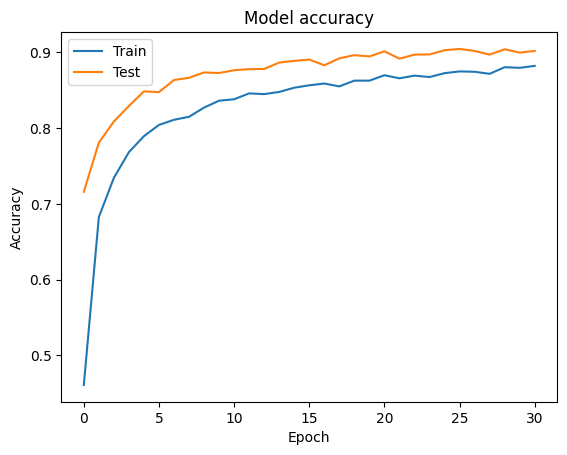

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

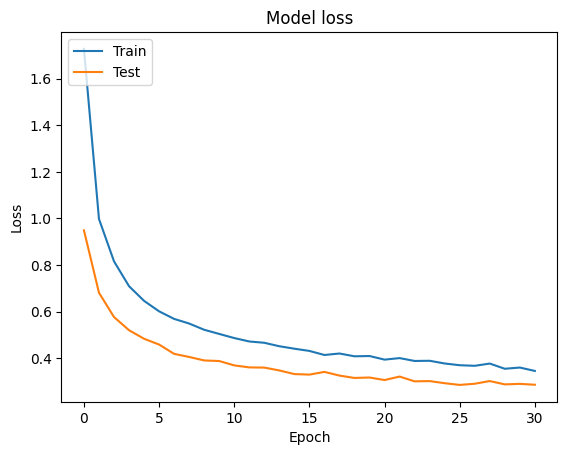

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Model Evaluation

In [ ]:
#Evaluation
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batchSize)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

117/117 ━━━━━━━━━━━━━━━━━━━━ 48s 413ms/step - accuracy: 0.9144 - loss: 0.2450
Validation Accuracy: 89.99%


In [ ]:
# Get true labels and predicted labels
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 409ms/step


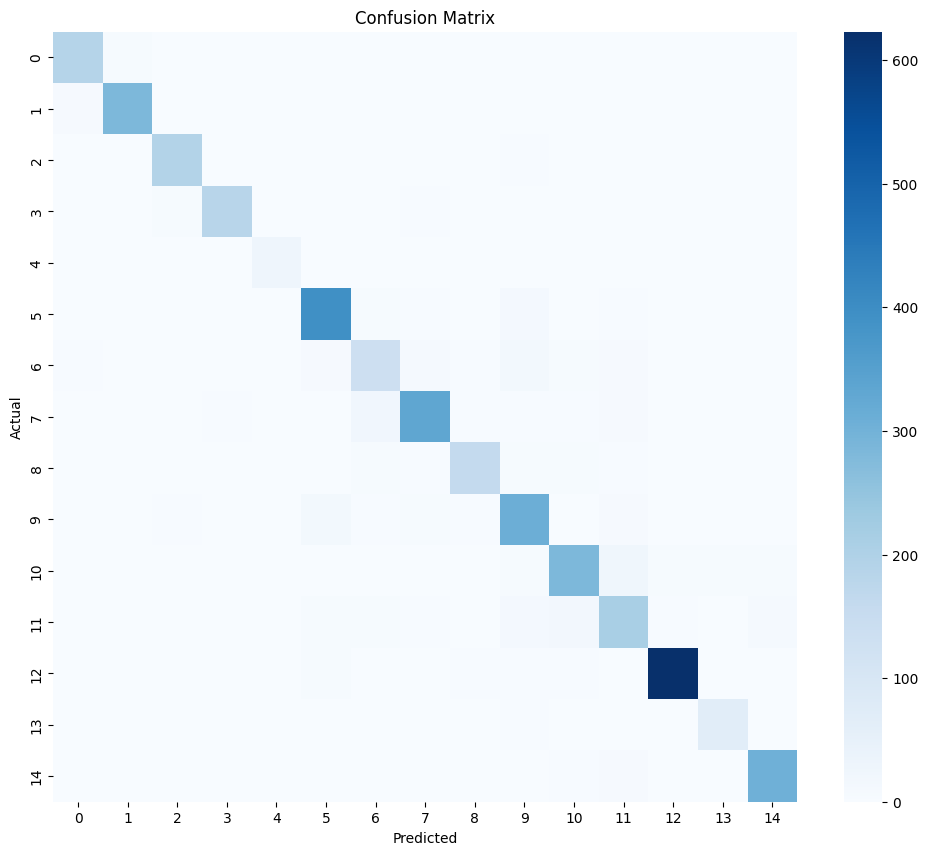

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Classification Report
class_labels = list(validation_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.92      0.94      0.93       199
                     Pepper__bell___healthy       0.96      0.96      0.96       295
                      Potato___Early_blight       0.95      0.97      0.96       200
                       Potato___Late_blight       0.95      0.92      0.93       200
                           Potato___healthy       0.93      0.93      0.93        30
                      Tomato_Bacterial_spot       0.91      0.93      0.92       425
                        Tomato_Early_blight       0.74      0.68      0.70       200
                         Tomato_Late_blight       0.91      0.88      0.89       381
                           Tomato_Leaf_Mold       0.90      0.84      0.87       190
                  Tomato_Septoria_leaf_spot       0.81      0.88      0.84       354
Tomato_Spider_mites_Two_spotted_spider_m

In [ ]:
#Save model
model.save('plant_disease_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
# Load the trained model
model = load_model('plant_disease_model.h5')

# Class names (same order as in your training generator)
class_indices = validation_generator.class_indices
class_names = list(class_indices.keys())

In [ ]:
# Path to your folder with new images
test_folder = '/content/drive/MyDrive/Afarinick Internship/plantvillage_test_images'
confidence_threshold = 0.8

# Loop over all images in the folder
for img_file in os.listdir(test_folder):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_folder, img_file)

        # Load and preprocess image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Batch size 1
        img_array /= 255.0

        # Predict
        pred_probs = model.predict(img_array)
        confidence = np.max(pred_probs)
        pred_class_index = np.argmax(pred_probs, axis=1)[0]

        if confidence >= confidence_threshold:
          predicted_label = class_names[pred_class_index]
          print(f"Prediction: {predicted_label}")
          print(f"Confidence: {confidence * 100:.2f}%")
        else:
          print("Prediction: Uncertain")
          print(f"Highest confidence: {confidence * 100:.2f}% (below threshold)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Potato___Early_blight
Confidence: 99.90%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction: Tomato_Early_blight
Confidence: 90.78%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Tomato_Septoria_leaf_spot
Confidence: 99.60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: Tomato__Tomato_YellowLeaf__Curl_Virus
Confidence: 97.54%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction: Pepper__bell___Bacterial_spot
Confidence: 98.28%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: Uncertain
Highest confidence: 78.93% (below threshold)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction: Uncertain
Highest confidence: 78.31% (below threshold)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Tomato_Late_blight
Confidence: 86.65%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Tomato_Late_blight
Confidence: 97.66%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Potato___Early_blight
Confidence: 91.21%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predic